In [4]:
#@title Setup
#@markdown Click the run button to install/import everything
!pip install rudalle==1.1.0rc0 --quiet 
# https://github.com/sberbank-ai/ru-dalle
# https://colab.research.google.com/drive/1wGE-046et27oHvNlBNPH07qrEQNE04PQ?usp=sharing

ALLOWED_MEMORY = 6.0 # choose your GPU memory in GB, min value 3.5GB
if ALLOWED_MEMORY < 4.5:
    DALLE_BS = 1
elif ALLOWED_MEMORY < 5.5:
    DALLE_BS = 2
elif ALLOWED_MEMORY < 6.5:
    DALLE_BS = 3
elif ALLOWED_MEMORY < 7.5:
    DALLE_BS = 4
elif ALLOWED_MEMORY < 8.5:
    DALLE_BS = 5
elif ALLOWED_MEMORY < 9.5:
    DALLE_BS = 6
elif ALLOWED_MEMORY < 10.5:
    DALLE_BS = 7
else:
    DALLE_BS = 8
    
if ALLOWED_MEMORY < 6.0:
    USE_SUPER_RES = False
else:
    USE_SUPER_RES = True
    
print('ruDALL-E batch size:', DALLE_BS)
print('super-resolution:', USE_SUPER_RES)

# import multiprocessing and torch
import multiprocessing
import torch
from psutil import virtual_memory

ram_gb = round(virtual_memory().total / 1024**3, 1)

print('CPU:', multiprocessing.cpu_count())
print('RAM GB:', ram_gb)
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device.type)

#import transformers, tools, and translation 
import transformers
import more_itertools
!pip install translators==4.9.5 > /dev/null
from tqdm.auto import tqdm
!pip install ruclip==0.0.1rc7

import translators
import ruclip
from rudalle.pipelines import generate_images, show, super_resolution
from rudalle import get_rudalle_model, get_tokenizer, get_vae, get_realesrgan
from rudalle.utils import seed_everything, torch_tensors_to_pil_list

# prepare models:
#dalle = get_rudalle_model('Malevich', pretrained=True, fp16=True, device=device)
device = 'cuda'
tokenizer = get_tokenizer()
vae = get_vae(dwt=True).to(device)  # for stable generations you should use dwt=False

# prepare utils:
clip, processor = ruclip.load('ruclip-vit-base-patch32-384', device=device)
clip_predictor = ruclip.Predictor(clip, processor, device, bs=8)

# generation code 
def generate_codebooks(text, tokenizer, dalle, top_k, top_p, images_num, image_prompts=None, temperature=1.0, bs=8,
                    seed=None, use_cache=True):
    vocab_size = dalle.get_param('vocab_size')
    text_seq_length = dalle.get_param('text_seq_length')
    image_seq_length = dalle.get_param('image_seq_length')
    total_seq_length = dalle.get_param('total_seq_length')
    device = dalle.get_param('device')
    text = text.lower().strip()
    input_ids = tokenizer.encode_text(text, text_seq_length=text_seq_length)
    codebooks = []
    for chunk in more_itertools.chunked(range(images_num), bs):
        chunk_bs = len(chunk)
        with torch.no_grad():
            attention_mask = torch.tril(torch.ones((chunk_bs, 1, total_seq_length, total_seq_length), device=device))
            out = input_ids.unsqueeze(0).repeat(chunk_bs, 1).to(device)
            has_cache = False
            if image_prompts is not None:
                prompts_idx, prompts = image_prompts.image_prompts_idx, image_prompts.image_prompts
                prompts = prompts.repeat(chunk_bs, 1)
            for idx in tqdm(range(out.shape[1], total_seq_length)):
                idx -= text_seq_length
                if image_prompts is not None and idx in prompts_idx:
                    out = torch.cat((out, prompts[:, idx].unsqueeze(1)), dim=-1)
                else:
                    logits, has_cache = dalle(out, attention_mask,
                                              has_cache=has_cache, use_cache=use_cache, return_loss=False)
                    logits = logits[:, -1, vocab_size:]
                    logits /= temperature
                    filtered_logits = transformers.top_k_top_p_filtering(logits, top_k=top_k, top_p=top_p)
                    probs = torch.nn.functional.softmax(filtered_logits, dim=-1)
                    sample = torch.multinomial(probs, 1)
                    out = torch.cat((out, sample), dim=-1)
            codebooks.append(out[:, -image_seq_length:].cpu())
    return codebooks

ruDALL-E batch size: 3
super-resolution: True
CPU: 16
RAM GB: 62.7
PyTorch version: 1.10.0+cu111
CUDA version: 11.1
cuDNN version: 8005
device: cuda
Looking in indexes: https://mirrors.cloud.tencent.com/pypi/simple


Using China server backend.


tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
vae --> ready


In [2]:
!pip install psutil

Looking in indexes: https://mirrors.cloud.tencent.com/pypi/simple
     |████████████████████████████████| 281 kB 803 kB/s eta 0:00:01


In [52]:
#@title Image Settings
#@markdown This section is definining your settings. 
#@markdown * num_tems is how many images you want generated per setting. There are 8 settings on each run.

text = "whisky on the ice in the whisky glass of a peculiar shape, whth dim neon light in the background." #@param {type:"string"}
num_items = 3 #@param {type:"slider", min:2, max:12, step:2}
model_name = 'Malevich' #@param ['Malevich', 'Surrealist', 'Malevich_v2', 'Kandinsky', 'Emojich']
total_num = num_items*3

# translation
text = translators.google(text, from_language='en', to_language='ru')

# build rudall model
dalle = get_rudalle_model(model_name, pretrained=True, fp16=True, device='cuda')

import random
seed_everything(random.randint(1,2**32-1))
pil_images = []
scores = []
for top_k, top_p, images_num in [
#     (2048, 0.995, 1),
    (1536, 0.99, 9),
#     (1024, 0.99, 8),
#     (1024, 0.98, 8),
#     (512, 0.97, 8),
#     (384, 0.96, 8),
#     (256, 0.95, 8),
#     (128, 0.95, 8),
]:
    _pil_images, _scores = generate_images(text, tokenizer, dalle, vae, top_k=top_k, images_num=images_num, bs=8, top_p=top_p)
    pil_images += _pil_images
    scores += _scores
#below is my stuff to limit one generation. Above is original stuff
#top_k = 2048 #@param {type:"slider", min:64, max:2048, step:64} 
#top_k = "1024" #@param['2048', '1536', '1024', '512', '384', '256', '128'] {type:"number"}
#top_p = "0.98" #@param['0.95', '0.96', '0.97', '0.98', '0.99', '0.995'] {type:"number"}
#top_p = 0.995 #@param {type:"slider", min:0.950, max:0.995, step:0.005}
#images_num = 12 #@param {type:"slider", min:1, max:12, step:1}
#codebook = generate_codebooks(text, tokenizer, dalle, top_k=top_k, images_num=images_num, top_p=top_p, bs=DALLE_BS)



◼️ Malevich is 1.3 billion params model from the family GPT3-like, that uses Russian language and text+image multi-modality.


  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

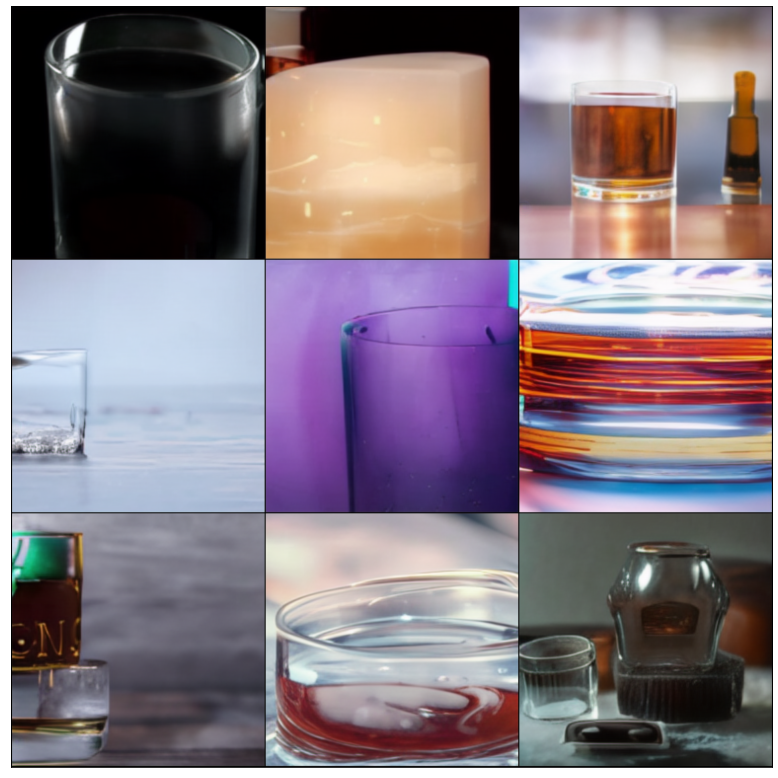

In [53]:
#@title Generate Images
#torch.cuda.empty_cache()

#create the images
show(pil_images, num_items)

In [54]:
len(pil_images)

9

In [56]:
type(pil_images[0])

PIL.Image.Image